In [33]:
import os 
import random 
import time 

import ale_py 
import gymnasium as gym 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim  
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv, 
    FireResetEnv, 
    MaxAndSkipEnv, 
    NoopResetEnv,
)
from stable_baselines3.common.buffers import ReplayBuffer 
import matplotlib.pyplot as plt 


In [29]:
env_id = "BreakoutNoFrameskip-v4" 
num_envs = 1 
total_timesteps = 5_000_000 
learning_rate = 1e-4 
buffer_size = 500_000
batch_size = 32
gamma = 0.99 
tau = 1.0 
target_network_frequency = 1000  
start_eps = 1 
end_eps = 0.01
exploration_duration = 1_000_000 
num_steps_before_training = 80_000 
train_frequency = 4
seed = None 



In [47]:
def make_env(env_id, capture_video, seed=None): 
    if capture_video: 
        env = gym.make(env_id, render_mode="rgb_array") 
        env = gym.wrappers.RecordVideo(env, "videos-dqn", episode_trigger=lambda e: True)
    else: 
        env = gym.make(env_id) 
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)

    if "FIRE" in env.unwrapped.get_action_meanings(): 
        env = FireResetEnv(env)
    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayscaleObservation(env)
    env = gym.wrappers.FrameStackObservation(env, 4)

    if seed is not None: 
        env.action_space.seed(seed)
    return env 
        


In [14]:
class QNetWork(nn.Module): 
    def __init__(self, envs): 
        super().__init__() 
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4), 
            nn.ReLU(), 
            nn.Conv2d(32, 64, kernel_size=4, stride=2), 
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=3, stride=1), 
            nn.ReLU(), 
            nn.Flatten(), 
            nn.Linear(64*7*7, 512), 
            nn.ReLU(), 
            nn.Linear(512, envs.single_action_space.n), 
        )
    
    def forward(self, x): 
        return self.network(x / 255.0) 
    
    

In [7]:
def linear_schedule(start_eps: float, end_eps: float, duration: int, t: int): 
    slope = (end_eps - start_eps) / duration 
    return max(slope * t + start_eps, end_eps)  
    

In [8]:
if seed is not None: 
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed) 
    if torch.cuda.is_available(): 
        torch.backends.cudnn.deterministic = True 
        

In [23]:
envs = gym.vector.SyncVectorEnv([
    lambda: make_env(
        env_id, 
        False, 
        None if seed is None else seed + i) for i in range(num_envs) 
], autoreset_mode=gym.vector.AutoresetMode.SAME_STEP) 


In [12]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else 
    "cpu"
) 



In [15]:
q_network = QNetWork(envs).to(device)  
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate) 
target_network = QNetWork(envs).to(device)  
target_network.load_state_dict(q_network.state_dict()) 

<All keys matched successfully>

In [ ]:
rb = ReplayBuffer(
    buffer_size, 
    envs.single_observation_space,  
    envs.single_action_space, 
    device, 
    optimize_memory_usage=True, 
    handle_timeout_termination=False, 
) 


/Users/huyle/.local/lib/python3.13/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.12GB > 2.82GB
  warnings.warn(


In [17]:
def np2torch(a, dtype=torch.float32, device=device): 
     return torch.as_tensor(a, dtype=dtype, device=device) 

In [18]:
episode_returns = [] 
losses = []  

In [30]:
start_time = time.time() 
obs, _ = envs.reset(seed=seed) 

for global_step in range(total_timesteps): 
    epsilon = linear_schedule(start_eps, end_eps, exploration_duration, global_step)  
    if random.random() < epsilon: 
        actions = np.array([envs.single_action_space.sample() for _ in range(num_envs)]) 
    else: 
        q_values = q_network(np2torch(obs))  
        actions = torch.argmax(q_values, dim=1).cpu().numpy()  
    # take a step in the environment  
    next_obs, rewards, dones, truncateds, infos = envs.step(actions) 

    for i, (done, truncated) in enumerate(zip(dones, truncateds)): 
        if done or truncated: 
            # This only appears when all lives are lost 
            if 'episode' in infos['final_info']: 
                ret = infos['final_info']['episode']['r'][0] 
                episode_returns.append(ret) 
                print(f"global_step={global_step}, episode={len(episode_returns)}, episode_return={ret}")
    
    # since we use same step 
    real_next_obs = next_obs.copy()  
    for i, truncated in enumerate(truncateds): 
        if truncated: 
            real_next_obs[i] = infos['final_obs'][i] 
    rb.add(obs, real_next_obs, actions, rewards, dones, infos) 

    obs = next_obs 
    
    # training
    if global_step > num_steps_before_training:  
        if global_step % train_frequency == 0:  
            data = rb.sample(batch_size)  
            with torch.no_grad(): 
                target_max, _ = target_network(data.next_observations).max(dim=1)
                td_target = data.rewards.flatten() + gamma * target_max * (1 - data.dones.flatten()) 
            pred = q_network(data.observations).gather(dim=1, index=data.actions).squeeze(1)
            loss = F.mse_loss(pred, td_target)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

            if global_step % 100 == 0: 
                print("steps per second:", int(global_step / (time.time() - start_time))) 
            
            # update target network 
            if global_step % target_network_frequency == 0: 
                for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
                    target_network_param.data.copy_(
                        tau * q_network_param.data + (1 - tau) * target_network_param.data 
                    )
envs.close() 


global_step=46, episode=453, episode_return=1.0
global_step=157, episode=454, episode_return=0.0
global_step=365, episode=455, episode_return=2.0
global_step=478, episode=456, episode_return=0.0
global_step=666, episode=457, episode_return=2.0
global_step=807, episode=458, episode_return=1.0
global_step=920, episode=459, episode_return=0.0
global_step=1031, episode=460, episode_return=0.0
global_step=1366, episode=461, episode_return=5.0
global_step=1585, episode=462, episode_return=3.0
global_step=1698, episode=463, episode_return=0.0
global_step=2108, episode=464, episode_return=9.0
global_step=2267, episode=465, episode_return=1.0
global_step=2582, episode=466, episode_return=5.0
global_step=2723, episode=467, episode_return=1.0
global_step=2933, episode=468, episode_return=2.0
global_step=3267, episode=469, episode_return=5.0
global_step=3530, episode=470, episode_return=4.0
global_step=3643, episode=471, episode_return=0.0
global_step=3807, episode=472, episode_return=1.0
global_s

KeyboardInterrupt: 

In [31]:
def smooth(x, a=0.1): 
    y = [x[0]]
    for xi in x[1:]: 
        yi = a * xi + (1 - a) * y[-1]
        y.append(yi) 
    return y 

Text(0.5, 1.0, 'Episode returns')

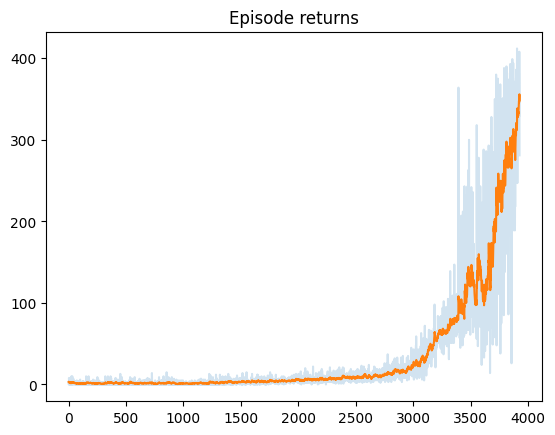

In [34]:
plt.plot(episode_returns, alpha=0.2) 
plt.plot(smooth(episode_returns)) 
plt.title("Episode returns")  


Text(0.5, 1.0, 'Losses')

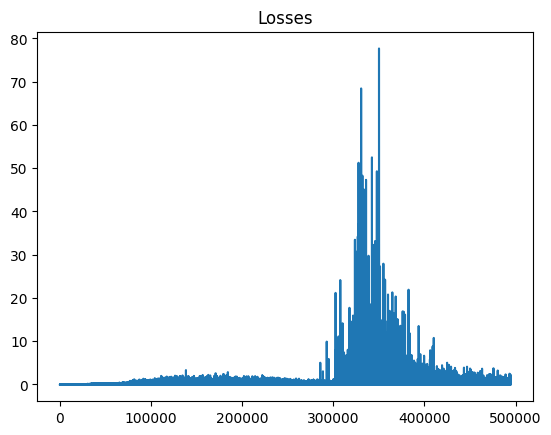

In [35]:
plt.plot(losses) 
plt.title("Losses") 


In [36]:
# save model 
model_path = "dqn_atari.pth"
torch.save(q_network.state_dict(), model_path)  

In [48]:
envs_eval = gym.vector.SyncVectorEnv([
    lambda: make_env(
        env_id, 
        True)
], autoreset_mode=gym.vector.AutoresetMode.SAME_STEP)  
model = QNetWork(envs_eval).to(device)  
model.load_state_dict(torch.load(model_path))   
model.eval() 


QNetWork(
  (network): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [49]:
from tokenize import N_TOKENS 
# evaluate the model 
n_episodes_eval = 10 
eval_returns = np.zeros(n_episodes_eval)  
obs, _ = envs_eval.reset()  

for i in range(n_episodes_eval):  
    episode_done = False
    while not episode_done:  
        if random.random() < epsilon:  
            actions = np.array([envs_eval.single_action_space.sample() for _ in range(envs_eval.num_envs)]) 
        else: 
            q_values = model(np2torch(obs))  
            actions = torch.argmax(q_values, dim=1).cpu().numpy()  
            
        obs, rewards, dones, truncateds, infos = envs_eval.step(actions) 
        
        if dones[0] or truncateds[0]: 
            if 'final_info' in infos: 
                if 'episode' in infos['final_info']: 
                    episode_done = True 
                    ret = infos['final_info']['episode']['r'][0] 
                    eval_returns[i] = ret 
                    print(f"episode={i}, episode_return={ret}")
                    
envs_eval.close() 
    

/Users/huyle/.local/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


episode=0, episode_return=359.0
episode=1, episode_return=421.0
episode=2, episode_return=139.0
episode=3, episode_return=357.0
episode=4, episode_return=364.0
episode=5, episode_return=361.0
episode=6, episode_return=409.0
episode=7, episode_return=309.0
episode=8, episode_return=291.0
episode=9, episode_return=388.0


Text(0.5, 1.0, 'Evaluation returns')

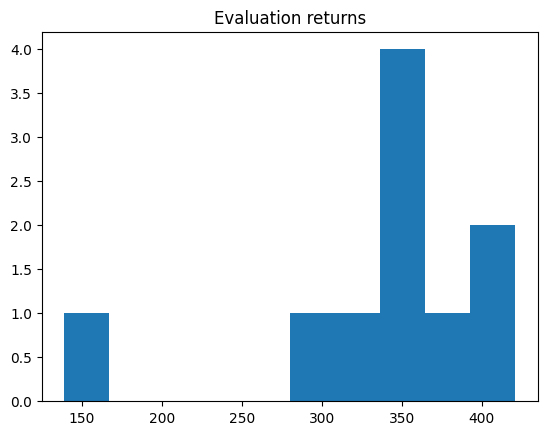

In [50]:
plt.hist(eval_returns) 
plt.title("Evaluation returns") 



In [52]:
from IPython.display import HTML 
from base64 import b64encode  

mp4 = open("videos-dqn/rl-video-episode-1.mp4", "rb").read()  
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()  
# Normal size in notebook, zoomed when in fullscreen
HTML(f"""
<style>
.video-container video {{
    width: 320px;
    height: 240px;
}}

.video-container video:fullscreen {{
    width: 100vw;
    height: 100vh;
    object-fit: contain;
    transform: scale(2);
    transform-origin: center;
}}
</style>
<div class="video-container">
    <video src="{data_url}" controls></video>
</div>
""")
